In [1]:
# jupyter extension that allows reloading functions from imports without clearing kernel :D
%load_ext autoreload
%autoreload 2

In [26]:
import cv2
import dlib
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import numpy as np

In [41]:
from utils import better_plotter
from utils import get_landmark_coords
from utils import crop_face_with_padding
from utils import resize_image_to_target_height
from utils import concat_images

In [28]:
# Initialize the face detector and facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('predictor/shape_predictor_68_face_landmarks.dat')

In [29]:
# Load the image
source_img = cv2.imread('images/vermeer.jpg')
# source_img = cv2.imread('images/manual_concat.jpg') 
target_img = cv2.imread('images/american-gothic.jpg')

## Extracting facial feature points

In [30]:
# Convert the image to grayscale
source_img_gray = cv2.cvtColor(source_img, cv2.COLOR_BGR2GRAY)
target_img_gray = cv2.cvtColor(target_img, cv2.COLOR_BGR2GRAY)

# Detect faces in the image
source_faces = detector(source_img_gray)
target_faces = detector(target_img_gray)

print("number of faces in [source] is", len(source_faces))
print("number of faces in [traget] is", len(target_faces))

number of faces in [source] is 1
number of faces in [traget] is 2


source face coordinates: (463, 701) (998, 1236)
target face coordinates: (112, 211) (261, 360)


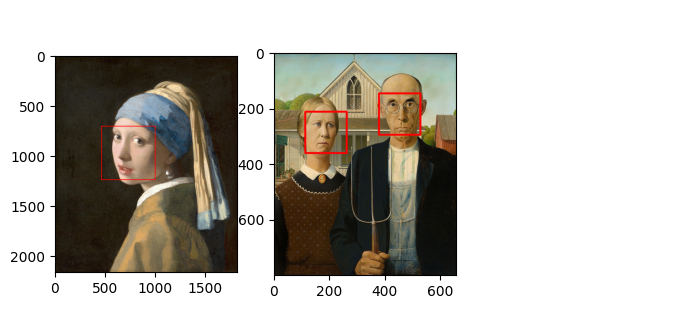

In [31]:
print(
    "source face coordinates:",
    (source_faces[0].left(), source_faces[0].top()), 
    (source_faces[0].right(), source_faces[0].bottom())
)

print(
    "target face coordinates:",
    (target_faces[0].left(), target_faces[0].top()), 
    (target_faces[0].right(), target_faces[0].bottom())
)

image_with_source_face = cv2.cvtColor(source_img.copy(), cv2.COLOR_BGR2RGB)
for i in range(len(source_faces)):
    cv2.rectangle(
        image_with_source_face, 
        (source_faces[i].left(), source_faces[i].top()), 
        (source_faces[i].right(), source_faces[i].bottom()),
        (255, 0, 0), 
        5
    )

image_with_target_face = cv2.cvtColor(target_img.copy(), cv2.COLOR_BGR2RGB)
for i in range(len(target_faces)):
    cv2.rectangle(
        image_with_target_face, 
        (target_faces[i].left(), target_faces[i].top()), 
        (target_faces[i].right(), target_faces[i].bottom()),
        (255, 0, 0), 
        5
    )

better_plotter([
    {
        "img": image_with_source_face,
        "title": ""
    },
    {
        "img": image_with_target_face,
        "title": ""
    }
], plot_size=(8, 4))

## Adjust the size of source face to the be similar size as the target face

Since our resulting image is based on the target image.

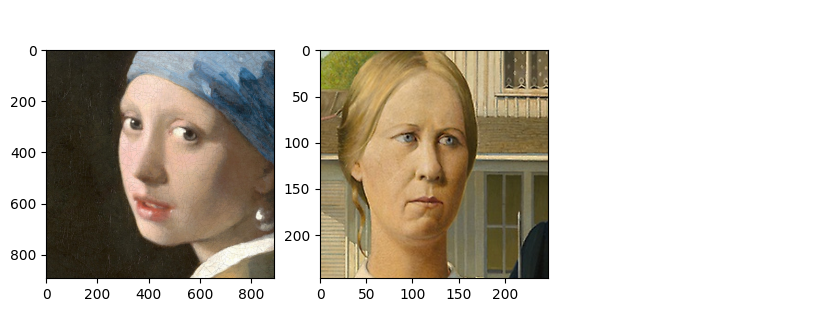

In [56]:
source_face = crop_face_with_padding(
    source_img, 
    source_faces[0]
)

target_face = crop_face_with_padding(
    target_img, 
    target_faces[0]
)

better_plotter([
    {
        "img": source_face,
        "title": ""
    },
    {
        "img": target_face,
        "title": ""
    }
], plot_size=(10, 4))

## Concate two faces

This solves the issue that, when triangulate with faces in two different images, we get different triangulation structure. 

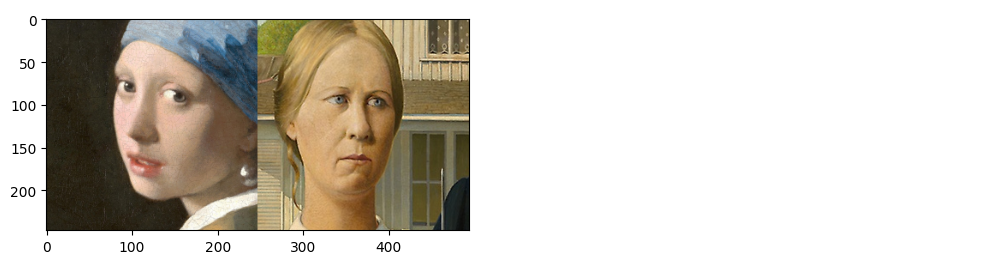

In [58]:
source_face_resized = resize_image_to_target_height(source_face, target_face)
concated_source_target = concat_images(source_face_resized, target_face)

better_plotter([
    {
        "img": concated_source_target,
        "title": ""
    }
], plot_size=(12, 3))

In [59]:
concated_gray = cv2.cvtColor(concated_source_target, cv2.COLOR_BGR2GRAY)
concated_faces = detector(concated_gray)

print("number of faces in [source] is", len(concated_faces))

number of faces in [source] is 2


## Start Triangulation

In [61]:
faces = concated_faces # source_faces
image_gray = concated_gray # source_img_gray
image = cv2.cvtColor(concated_source_target, cv2.COLOR_BGR2RGB)

face [(277, 45) (427, 194)] 	 number of landmarks: 68 	 number of triangles: 107
face [(45, 45) (194, 194)] 	 number of landmarks: 68 	 number of triangles: 107


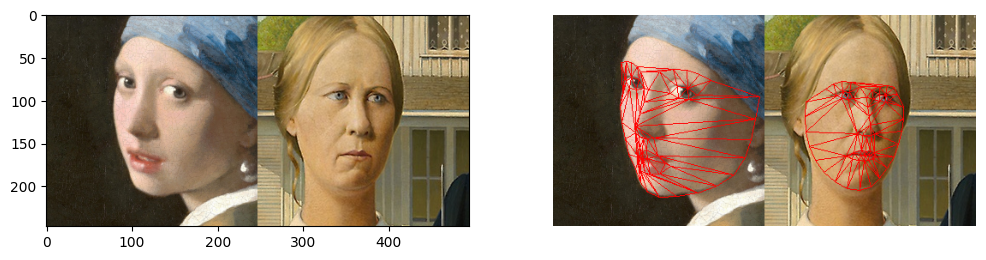

In [75]:
image_triangulation = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)

# Get landmarks and perform Delaunay triangulation on the first face as a reference
if faces:
    reference_landmarks = predictor(image_gray, faces[0])
    reference_coords = get_landmark_coords(reference_landmarks)
    tri = Delaunay(reference_coords)

# Apply triangulation to each face
for face in faces:
    landmarks = predictor(image_gray, face)
    coords = get_landmark_coords(landmarks)

    triangle_counts = 0
    # Draw triangles
    for triangle in tri.simplices:
        pt1 = tuple(coords[triangle[0]])
        pt2 = tuple(coords[triangle[1]])
        pt3 = tuple(coords[triangle[2]])

        cv2.line(image_triangulation, pt1, pt2, (255, 0, 0), 1)
        cv2.line(image_triangulation, pt2, pt3, (255, 0, 0), 1)
        cv2.line(image_triangulation, pt3, pt1, (255, 0, 0), 1)
        triangle_counts += 1

    print(
        "face", face, "\t",
        "number of landmarks:", len(coords), "\t",
        "number of triangles:", triangle_counts
    )

better_plotter([
    {
        "img": cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
        "title": ""
    },
    {
        "img": image_triangulation,
        "title": ""
    }
], plot_size=(12, 6))

# print

## Warping

We want to warp all triangles to from source to the target, following this equation:

$$
\begin{bmatrix}
x_t \\ y_t
\end{bmatrix} = 
\begin{bmatrix}
a & b \\ c & d
\end{bmatrix}
\begin{bmatrix}
x \\ y
\end{bmatrix} +
\begin{bmatrix}
t_x \\ t_y
\end{bmatrix}
$$

where:

- ($x$, $y$) is the source pixel location
- ($x_t$, $y_t$) is the target pixel location

### Reference

- https://docs.opencv.org/4.x/d4/d61/tutorial_warp_affine.html